In [25]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import pandas as pd
import networkx as nx
from sklearn import cluster, covariance, manifold
from sklearn.impute import KNNImputer
import ipywidgets as widgets
from IPython.display import display 
import edhec_risk_kit as erk
from alpha_vantage.timeseries import TimeSeries
import alpaca_trade_api as tradeapi
from config import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
#SET ALAPACA API ENVIRONMENT VARIABLES 

HEADERS={'APCA-API-KEY-ID':API_KEY,'APCA-API-SECRET-KEY':SECRET_KEY}
alpaca=tradeapi.REST(API_KEY,SECRET_KEY,BASE_URL,api_version='v2')

In [27]:
#SET ALPHA VINTAGE ENVIRONMENT VARIABLES 
ts=TimeSeries(key=ALPHA_API_KEY,output_format='pandas')

In [28]:
def cross_validated_GraphicalLasso(data,alphaMax,nLambdas:int,StockNames=None,frac=0.1):
    '''cross_validated_lasso_regression takes in a dataset and returns the factor loadings using lasso regression and cross validating the choice of lambda
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            printLoadings: boolean, if true, prints the coeficients

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  Also, it uses a scaled version of LASSO argument, so here I scale when converting lambda to alpha
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''

    #Do CV Lasso
    alphas = np.linspace(0.001,alphaMax,nLambdas)
    graph={}
    for alpha in alphas:
        P=compute_precision(alpha,data,frac)
        check=np.count_nonzero(P,axis=1)==1
        if check.sum()>=10:
            graph={"index":np.where(check==1),
                    "Precision":P,
                    "Alpha":alpha,
                    "Names":data.columns}
            break
    return graph

In [29]:
def compute_precision(alpha,data,frac,n_samples=20):
    '''
    Compute the average precision matrix of n subsamples given size n and alpha value
    '''
    
    d=data.shape[1]
    S=np.zeros((d,d))
    for i in range(1,n_samples):
        SampleX=data.sample(frac=frac).values
        cov = covariance.GraphicalLasso(alpha=alpha,max_iter=1000).fit(SampleX)
        S=S+cov.precision_
    return S/n_samples

In [30]:
def Graph_Sparsity(Results):
    columns=Results['Names']
    idx=Results['index'][0]
    A=np.around(Results['Precision'], decimals=3)
    G=nx.from_numpy_matrix(A,create_using=nx.Graph())
    pos=nx.spring_layout(G)        
    nx.draw(G,pos,with_labels=False,node_size=30,node_color='r',edge_color='grey')
    labels={}
    for p in pos:  # raise text positions
        pos[p][1] += 0.08
        labels.update({p:columns[p]})
    
    nx.draw_networkx_labels(G, pos,labels=labels)
    plt.show()
    print(columns[idx])
    return columns[idx]

In [31]:
import time
def get_Component_Data(Stocks):
    '''
    Return dataframe with all the stock prices in the list "Stocks"
    '''
    
    Data=pd.DataFrame()
    ignore=['1. open', '2. high', '3. low','5. volume']
    for stock in Stocks: 
        try:
            price=ts.get_monthly(stock)[0]
        except:
            break
            
        price=price.drop(ignore,axis=1)
        price.columns=[stock]
        if Data.empty:
            Data=price
        else:
            Data=pd.merge(Data,price,how='outer',on='date')
        time.sleep(12)
            
    return Data
        
    

In [32]:
Stocks=['AAPL',
'ABBV',
'ABT',
'ACN',
'ADBE',
'AGN',
'AIG',
'ALL',
'AMGN',
'AMT',
'AMZN',
'AXP',
'BA',
'BAC',
'BIIB',
'BK',
'BKNG',
'BLK',
'BMY',
'BRK.B',
'C',
'CAT',
'CHTR',
'CL',
'CMCSA',
'COF',
'COP',
'COST',
'CSCO',
'CVS',
'CVX',
'DD',
'DHR',
'DIS',
'DOW',
'DUK',
'EMR',
'EXC',
'F',
'FB',
'FDX',
'GD',
'GE',
'GILD',
'GM',
'GOOG',
'GOOGL',
'GS',
'HD',
'HON',
'IBM',
'INTC',
'JNJ',
'JPM',
'KHC',
'KMI',
'KO',
'LLY',
'LMT',
'LOW',
'MA',
'MCD',
'MDLZ',
'MDT',
'MET',
'MMM',
'MO',
'MRK',
'MS',
'MSFT',
'NEE',
'NFLX',
'NKE',
'NVDA',
'ORCL',
'OXY',
'PEP',
'PFE',
'PG',
'PM',
'PYPL',
'QCOM',
'RTX',
'SBUX',
'SLB',
'SO',
'SPG',
'T',
'TGT',
'TMO',
'TXN',
'UNH',
'UNP',
'UPS',
'USB',
'V',
'VZ',
'WBA',
'WFC',
'WMT',
'XOM',
]

In [33]:
#Data=get_Component_Data(Stocks)

# Data Cleaning 

In [34]:
SP=pd.read_csv(r'SPConstituents.csv',header=0, index_col=0,parse_dates=True).sort_index()[:-1]

In [35]:
SP.shape

(240, 101)

In [36]:
SP.index=SP.index.to_period('M')
SP.tail()

,AAPL,ABBV,ABT,ACN,ADBE,AGN,AIG,ALL,AMGN,AMT,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
2020-01,309.51,81.02,87.14,205.21,351.14,186.64,50.26,118.54,216.05,231.74,...,272.45,179.42,103.52,53.22,198.97,59.44,50.85,46.94,114.49,62.12
2020-02,273.36,85.71,77.03,180.59,345.12,190.67,42.16,105.25,199.73,226.80,...,254.96,159.81,90.49,46.44,181.76,54.16,45.76,40.85,107.68,51.44
2020-03,254.29,76.19,78.91,163.26,318.24,177.10,24.25,91.73,202.73,217.75,...,249.38,141.04,93.42,34.45,161.12,53.73,45.75,28.70,113.62,37.97
2020-04,293.80,82.20,92.09,185.19,353.64,187.34,25.43,101.72,239.22,238.00,...,292.47,159.79,94.66,36.50,178.72,57.45,43.29,29.05,121.55,46.47
2020-05,303.74,NaN,NaN,NaN,366.78,NaN,NaN,NaN,233.33,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,40.66,NaN,NaN,NaN


In [37]:
Desc=SP.describe()
Desc

,AAPL,ABBV,ABT,ACN,ADBE,AGN,AIG,ALL,AMGN,AMT,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
count,240.000000,87.000000,239.000000,225.000000,240.000000,239.000000,239.000000,239.000000,240.000000,239.000000,...,239.000000,239.000000,239.000000,239.000000,145.000000,239.000000,240.000000,239.000000,239.000000,239.000000
mean,176.800495,68.520460,50.644142,69.536978,79.578017,100.791381,52.950962,54.009247,98.226735,67.217406,...,94.587992,96.738285,80.636611,33.914561,120.474207,42.871255,48.643375,44.673808,64.377741,71.915523
std,162.849175,17.305406,11.674942,51.064735,80.613827,87.150530,19.552649,22.925839,53.876621,55.991089,...,69.557514,38.242233,20.395299,10.934447,54.399373,8.646456,18.119589,12.132149,18.265210,18.354409
min,14.140000,36.920000,33.190000,12.750000,16.700000,21.070000,0.420000,16.830000,41.700000,1.410000,...,19.650000,37.190000,41.180000,14.310000,49.350000,27.440000,23.860000,12.100000,43.630000,31.900000
25%,56.355000,56.110000,42.585000,29.070000,32.850000,30.645000,41.715000,35.370000,57.250000,29.030000,...,50.500000,62.370000,63.750000,24.810000,76.480000,35.450000,34.970000,34.040000,50.805000,60.660000
50%,124.725000,65.160000,48.000000,48.490000,41.530000,55.250000,55.700000,50.440000,68.020000,45.540000,...,65.750000,92.020000,74.320000,31.740000,99.560000,43.270000,42.805000,46.970000,56.320000,78.090000
75%,226.212500,79.920000,54.810000,98.260000,82.952500,168.145000,64.705000,64.860000,152.177500,94.820000,...,115.430000,120.470000,98.595000,42.235000,161.120000,49.625000,60.141250,54.320000,74.585000,86.370000
max,667.105000,115.830000,92.090000,210.570000,366.780000,331.150000,117.500000,118.540000,241.070000,238.000000,...,293.980000,199.270000,127.320000,60.030000,271.310000,61.400000,96.630000,72.340000,121.550000,102.410000


In [38]:
#Select stocks that didn't exist in 2006
keep=SP["2006"].isna().all()
keep=keep[keep==False].index.tolist()


In [39]:
SP=SP[keep]

In [40]:
SP.tail()

,AAPL,ABT,ACN,ADBE,AGN,AIG,ALL,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
2020-01,309.51,87.14,205.21,351.14,186.64,50.26,118.54,216.05,231.74,2008.72,...,120.65,272.45,179.42,103.52,53.22,59.44,50.85,46.94,114.49,62.12
2020-02,273.36,77.03,180.59,345.12,190.67,42.16,105.25,199.73,226.80,1883.75,...,114.14,254.96,159.81,90.49,46.44,54.16,45.76,40.85,107.68,51.44
2020-03,254.29,78.91,163.26,318.24,177.10,24.25,91.73,202.73,217.75,1949.72,...,99.93,249.38,141.04,93.42,34.45,53.73,45.75,28.70,113.62,37.97
2020-04,293.80,92.09,185.19,353.64,187.34,25.43,101.72,239.22,238.00,2474.00,...,116.07,292.47,159.79,94.66,36.50,57.45,43.29,29.05,121.55,46.47
2020-05,303.74,NaN,NaN,366.78,NaN,NaN,NaN,233.33,NaN,2367.61,...,113.65,NaN,NaN,NaN,NaN,NaN,40.66,NaN,NaN,NaN


In [41]:
SP_rets=SP.pct_change()

In [42]:
SP_rets.head()

,AAPL,ABT,ACN,ADBE,AGN,AIG,ALL,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,VZ,WBA,WFC,WMT,XOM
2000-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-07,-0.029973,-0.068671,NaN,-0.119231,0.027907,-0.253702,0.238652,-0.075587,0.028544,-0.170201,...,-0.133789,-0.045948,0.161334,-0.002547,-0.003117,-0.079906,-0.031066,0.070968,-0.041298,0.021529
2000-08,0.199370,0.054699,NaN,0.135371,0.116018,0.016536,0.055152,0.167385,-0.151586,0.377365,...,0.121849,0.155360,-0.079185,-0.056340,0.134445,-0.069091,0.054505,0.041205,-0.137919,0.018082
2000-09,-0.577453,0.086589,NaN,0.194615,0.054168,0.073480,0.194979,-0.078881,0.036009,-0.073735,...,-0.288390,0.044752,-0.020870,0.016955,0.045016,0.113051,0.153542,0.063180,0.010498,0.091499
2000-10,-0.240388,0.110387,NaN,-0.510238,-0.037538,0.024140,0.158273,-0.170271,0.086230,-0.047086,...,0.032842,0.107646,0.203903,0.077510,0.063297,0.193435,0.202688,0.008054,-0.057137,0.000898


In [43]:
#fill nan using K-nearest Neighbor  I
imputer=KNNImputer(n_neighbors=2)
#SP_rets=SP_rets[:"2020-4"]
Data=imputer.fit_transform(SP_rets)

In [44]:
Data=pd.DataFrame(Data,index=SP_rets.index,columns=SP_rets.columns)

In [45]:
Results=cross_validated_GraphicalLasso(Data,0.1,100,frac=0.5)

C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.468e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 5.405e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -7.294e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -6.968e-04
  % (max_iter, d_gap), C

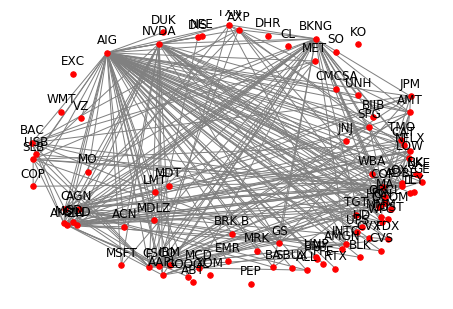

Index(['ABT', 'CL', 'DHR', 'EXC', 'KO', 'LLY', 'MDT', 'NEE', 'PEP', 'SO',
       'WMT', 'XOM'],
      dtype='object')


In [46]:
EQT=Graph_Sparsity(Results)

# Equal weighted Portfolio

In [47]:
EQT=EQT.tolist()
n=len(EQT)
weight=np.repeat(1/n,n)
Test_return=SP.loc["2019":,EQT].pct_change()
portfolio_returns=Test_return.dot(weight)
portfolio_returns.name='Top Ind'

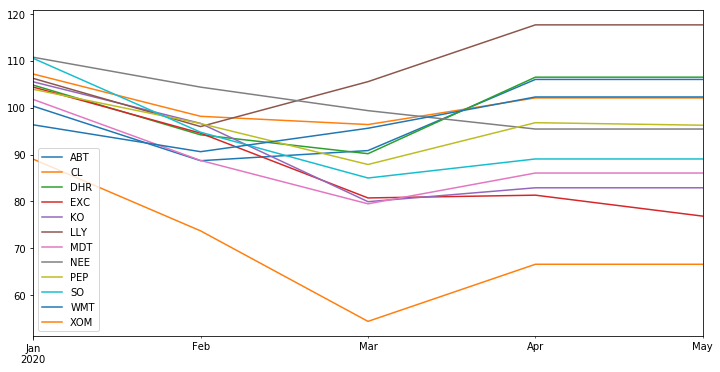

In [48]:
returns=SP_rets[EQT]["2020":]
Index=100*(1+returns).cumprod()
Index.plot(legend=True,figsize=(12,6))

In [53]:
returns.corr()

,ABT,CL,DHR,EXC,KO,LLY,MDT,NEE,PEP,SO,WMT,XOM
ABT,1.000000,0.745589,0.921428,0.407676,0.379118,0.865354,0.796132,-0.005481,0.736796,0.571852,0.852561,0.736982
CL,0.745589,1.000000,0.851258,0.807001,0.722888,0.760861,0.881865,0.660957,0.829853,0.952008,0.377274,0.558421
DHR,0.921428,0.851258,1.000000,0.716024,0.692614,0.710022,0.943707,0.225552,0.939892,0.773842,0.584782,0.866393
EXC,0.407676,0.807001,0.716024,1.000000,0.961455,0.261566,0.827704,0.724726,0.886936,0.918099,-0.125126,0.624801
KO,0.379118,0.722888,0.692614,0.961455,1.000000,0.138109,0.854230,0.635621,0.890574,0.877439,-0.141281,0.725568
LLY,0.865354,0.760861,0.710022,0.261566,0.138109,1.000000,0.569873,0.183704,0.469826,0.530015,0.820641,0.322575
MDT,0.796132,0.881865,0.943707,0.827704,0.854230,0.569873,1.000000,0.419011,0.967948,0.891678,0.392436,0.873690
NEE,-0.005481,0.660957,0.225552,0.724726,0.635621,0.183704,0.419011,1.000000,0.392156,0.780474,-0.373361,-0.011193
PEP,0.736796,0.829853,0.939892,0.886936,0.890574,0.469826,0.967948,0.392156,1.000000,0.855813,0.282235,0.891283
SO,0.571852,0.952008,0.773842,0.918099,0.877439,0.530015,0.891678,0.780474,0.855813,1.000000,0.121700,0.579726


In [56]:
returns.corr().min().sort_values()

NEE   -0.373361
WMT   -0.373361
KO    -0.141281
EXC   -0.125126
XOM   -0.011193
ABT   -0.005481
SO     0.121700
LLY    0.138109
DHR    0.225552
PEP    0.282235
CL     0.377274
MDT    0.392436
dtype: float64

In [38]:
SPY=ts.get_daily('SPY')[0]
SPY=SPY.drop(['1. open', '2. high', '3. low','5. volume'],axis=1)
SPY=SPY.sort_index()
SPY.columns=['SPY']
SPY=SPY['SPY'].pct_change()
SPY=SPY["2020-05-10":]

In [39]:
3656.58*(1+SPY).cumprod()

date
2020-05-11    3657.330222
2020-05-12    3584.433691
2020-05-13    3521.039967
2020-05-14    3563.177413
2020-05-15    3579.557251
2020-05-18    3688.589454
2020-05-19    3650.703264
2020-05-20    3712.721582
2020-05-21    3687.089011
Name: SPY, dtype: float64

In [40]:
portfolio_returns

2019-01         NaN
2019-02    0.050721
2019-03    0.030624
2019-04    0.010725
2019-05   -0.026345
2019-06    0.043274
2019-07   -0.008499
2019-08    0.023021
2019-09    0.019686
2019-10   -0.016983
2019-11    0.006019
2019-12    0.032126
2020-01    0.033495
2020-02   -0.099427
2020-03   -0.053063
2020-04    0.093254
2020-05   -0.006061
Freq: M, Name: Top Ind, dtype: float64

In [41]:
summary=pd.merge(SPY,portfolio_returns,on=SPY.index)
summary=summary.set_index('key_0')
summary.iloc[0]=0

KeyError: DatetimeIndex(['2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
               '2020-05-15', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21'],
              dtype='datetime64[ns]', name='date', freq=None)

In [ ]:
wealth_index=1000*(1+summary).cumprod()
wealth_index.plot()

In [ ]:
erk.summary_stats(summary)

In [ ]:
for eqt in EQT:
    r=alpaca.submit_order(eqt,2,'buy','market','gtc')
    Account=alpaca.get_account()
    status=r.side +" "+r.qty+" "+r.symbol+" at $"+Account.initial_margin +" Acct Val:"+Account.portfolio_value
    print(status)

In [4]:
R=alpaca.get_portfolio_history(date_start='2020-05-08',timeframe='1D').df

In [5]:
rets=R['equity'].pct_change().dropna()

In [6]:
rets

2020-05-11 09:30:00-04:00    0.000146
2020-05-12 09:30:00-04:00   -0.000344
2020-05-13 09:30:00-04:00    0.000000
2020-05-14 09:30:00-04:00   -0.000302
2020-05-15 09:30:00-04:00   -0.000003
2020-05-18 09:30:00-04:00    0.000806
2020-05-19 09:30:00-04:00    0.000000
2020-05-20 09:30:00-04:00   -0.000547
2020-05-21 09:30:00-04:00    0.000000
2020-05-22 09:30:00-04:00   -0.000121
Name: equity, dtype: float64

In [58]:
rets.index=rets.index.to_period("1d")

C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1104: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [7]:
SPY=ts.get_daily('SPY')[0]
SPY=SPY.drop(['1. open', '2. high', '3. low','5. volume'],axis=1)
SPY=SPY.sort_index()
SPY.columns=['SPY']
SPY=SPY['SPY'].pct_change()
SPY=SPY["2020-05-10":]

In [8]:
summary=pd.merge(SPY,rets,on=SPY.index)
summary=summary.set_index('key_0')

,SPY,equity
key_0,,
2020-05-11,0.000205,0.000146
2020-05-12,-0.019932,-0.000344
2020-05-13,-0.017686,0.000000
2020-05-14,0.011967,-0.000302
2020-05-15,0.004597,-0.000003
2020-05-18,0.030460,0.000806
2020-05-19,-0.010271,0.000000
2020-05-20,0.016988,-0.000547
2020-05-21,-0.006904,0.000000


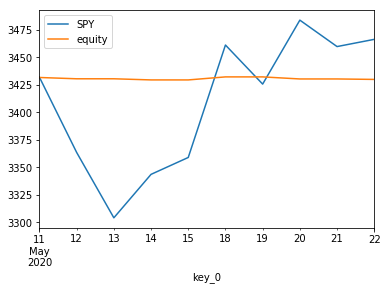

In [9]:
wealth_index=3431.13*(1+summary).cumprod()
wealth_index.plot()
summary

In [10]:
erk.summary_stats(summary)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
SPY,0.012323,0.054587,0.374511,2.323144,0.022030,0.019932,-0.315233,-0.037265
equity,-0.000439,0.001255,1.039512,4.202027,0.000485,0.000547,-23.607416,-0.000668


In [11]:
wealth_index

,SPY,equity
key_0,,
2020-05-11,3431.833966,3431.632317
2020-05-12,3363.431942,3430.451322
2020-05-13,3303.946820,3430.451322
2020-05-14,3343.486240,3429.414435
2020-05-15,3358.856163,3429.405514
2020-05-18,3461.165880,3432.168260
2020-05-19,3425.615600,3432.168260
2020-05-20,3483.810118,3430.290059
2020-05-21,3459.757948,3430.290059


In [ ]:
summary

In [ ]:
wealth_index['SPY']-wealth_index['equity']